# Estimating Selection Effects

This notebook accumulates a set of samples in detector-frame masses and distances that are *detected* and corresponding weights (probability density in mass-distance space) that can be used to estimate the selection effects of our hypothetical search.

We choose to use broad distributions: flat in log-mass and log-distance.  These are chosen for simplicity, not for efficiency (the most efficient method would duplicate the detected mass and distance distribution given the population).

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [19]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from scipy.interpolate import interp1d, RectBivariateSpline
import seaborn as sns
from tqdm import tqdm_notebook

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

First, we load and construct and interpolator to give the optimal SNR for masses and distances:

In [7]:
with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    osnrs = array(f['SNR'])
    
rbs = RectBivariateSpline(ms, ms, osnrs)

def optimal_snr(m1, m2, d):
    return rbs.ev(m1, m2)/d

Then we construct an interpolator for the distribution of angular factors:

In [12]:
with h5py.File('thetas.h5', 'r') as f:
    ts = array(f['Theta'])
    
ts = np.append([0, 1], ts)
ts = np.sort(ts)

theta_icdf = interp1d(linspace(0, 1, len(ts)), ts)

Now we get the weight function for the events (remember---uniform in log):

In [23]:
MMin = 3
MMax = 200

dlmax = Planck15.luminosity_distance(3).to(u.Gpc).value
dlmin = 1e-1 # 100 Mpc---represents less than 1/1000 of the volume to 1Gpc, let alone our survey

def weights(m1det, m2det, dl):
    mnorm = 2.0/(log(MMax/MMin)**2) # 2 because we draw in the half-plane with m2 < m1
    dlnorm = 1.0/(log(dlmax/dlmin))
    
    return mnorm*dlnorm/(m1det*m2det*dl)

def draw_m1m2dl(size=1):
    m1s = exp(log(MMin) + log(MMax/MMin)*rand(size))
    m2s = exp(log(MMin) + log(MMax/MMin)*rand(size))
    dls = exp(log(dlmin) + log(dlmax/dlmin)*rand(size))
    
    # Swap to get m1 > m2    
    if np.isscalar(m1s):
        m1s, m2s = sort((m1s, m2s))
    else:
        h = where(m1s < m2s, m2s, m1s)
        l = where(m1s < m2s, m1s, m2s)
        
        m1s = h
        m2s = l
        
    return (m1s, m2s, dls)

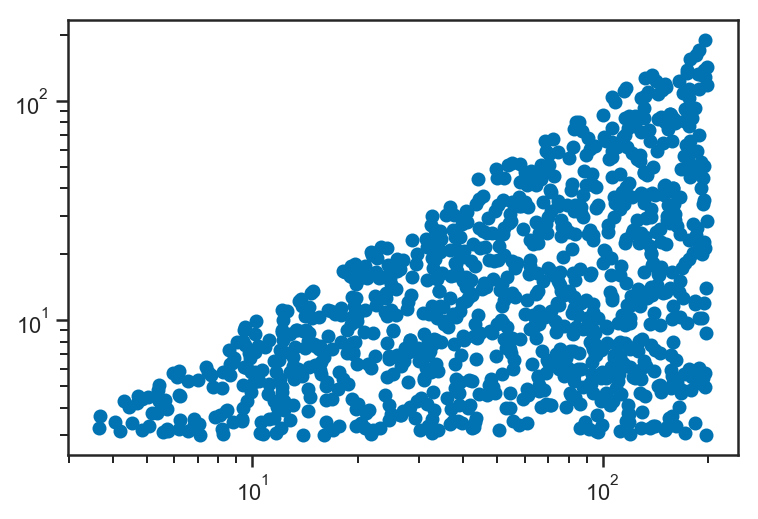

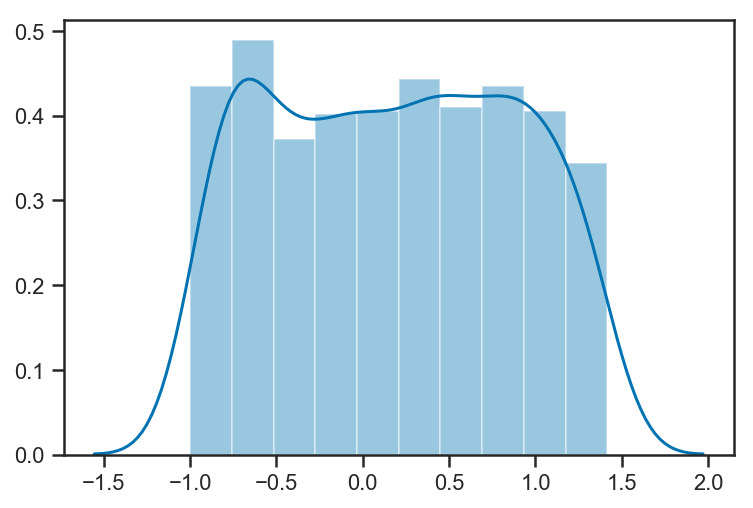

In [24]:
m1s, m2s, dls = draw_m1m2dl(1000)
scatter(m1s, m2s)
xscale('log')
yscale('log')
figure()

sns.distplot(log10(dls))

Here we draw the SNRs of the masses and distances:

In [25]:
def draw_snrs(m1s, m2s, dls):
    n = len(m1s)
    
    t = theta_icdf(rand(n))
    
    return t*optimal_snr(m1s, m2s, dls) + randn(n)

And here we draw the detected events:

In [39]:
m1s_det = zeros((0,))
m2s_det = zeros((0,))
dls_det = zeros((0,))
wts_det = zeros((0,))

chunk_size = 1000
N_gen = 0
N_desired = 2000000

with tqdm_notebook(total=N_desired) as bar:
    while len(m1s_det) < N_desired:
        m1, m2, dl = draw_m1m2dl(size=chunk_size)
        rho = draw_snrs(m1, m2, dl)
        
        N_gen += chunk_size
        
        s = rho > 8
        
        if np.any(s):
            m1s_det = np.append(m1s_det, m1[s])
            m2s_det = np.append(m2s_det, m2[s])
            dls_det = np.append(dls_det, dl[s])
            wts_det = np.append(wts_det, weights(m1[s], m2[s], dl[s]))
            
            bar.update(count_nonzero(s))
            

And here we save them to HDF5:

In [40]:
with h5py.File('selected.h5', 'w') as f:
    f.attrs['N_gen'] = N_gen
    f.create_dataset('m1det', data=m1s_det, compression='gzip', shuffle=True)
    f.create_dataset('m2det', data=m2s_det, compression='gzip', shuffle=True)
    f.create_dataset('dl', data=dls_det, compression='gzip', shuffle=True)
    f.create_dataset('wt', data=wts_det, compression='gzip', shuffle=True)

A quick test, with a distribution that is close to our reference distribution---should come out to be close to 4000 events expected:

In [41]:
z = linspace(0, 3, 1000)
d = Planck15.luminosity_distance(z).to(u.Gpc).value

z_of_d = interp1d(d, z)

def dNdm1dm2ddl(m1det, m2det, dl):
    z = z_of_d(dl)
    
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)
    
    low_cut = where(m2 < 5, 0, 1)
    high_cut = where(m1 > 40, 0, 1)
    
    dVdz = Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value*4*pi
    dzddl = 1/(dl/(1+z) + (1+z)*Planck15.hubble_distance.to(u.Gpc).value/sqrt((1+z)**3*0.3 + 0.7))
    
    alpha = 0.75
    beta = 0.0
    gamma = 3
    
    MMin = 5
    MMax = 40
    
    m1norm = (1-alpha)/(MMax**(1-alpha) - MMin**(1-alpha))
    m2norm = (beta+1)/(m1**(beta+1) - MMin**(beta+1))
    
    dN = m1norm*m2norm*m1**(-alpha)*m2**beta*(1+z)**(gamma-1)*dVdz*dzddl/(1+z)**2
    
    return low_cut * dN * high_cut

Here we calculate the number of events expected and also the Monte-Carlo uncertainty on that number, and compare to the intrinsic statistical uncertainty, $\sqrt{N}$.

In [45]:
xs = dNdm1dm2ddl(m1s_det, m2s_det, dls_det)/wts_det
s = np.sum(xs)
s2 = np.sum(xs*xs)

v = s2 - s*s/N_gen # var(wt0 + wt1 + ... + wtN + 0 + ... + 0) = N_gen*var([wt0, wt1, ..., wtN, 0, ..., 0])

Nex = 0.5*5*100*s/N_gen
sigma_Nex = sqrt(v)*0.5*5*100/N_gen

Neff = Nex*Nex/(sigma_Nex*sigma_Nex)

Nex, sigma_Nex, sqrt(Nex)

(3644.5868049007454, 37.00101326104634, 60.370413323918406)